# Data preparation and feature selection

We present different techniques for encode the data and prepare them for applying ML algorithms. Also we present techniques for feature selection.

By Mario Martín, modify by Manuel Gijón on April 2024.

----

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.neighbors as nb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    GridSearchCV
)
from sklearn.feature_selection import (
    mutual_info_classif,
    SelectKBest,
)

from sklearn.metrics import make_scorer, precision_score, recall_score

%matplotlib inline

# DATA TRANSFORMATION: Normalization

In [37]:
import pandas as pd

df = pd.read_csv("dades_preprocessades.csv")
X_bank = df.values[:,2:]
y_bank = df.values[:,1]

In [38]:
df.describe()

,Year_1,Current assets_1,Cost goods sold_1,DEP and AMO_1,EBITDA_1,Inventory_1,Net income_1,Total Receivables_1,Market value_1,Net sales_1,...,Net sales_3,Total assets_3,Long-term debt_3,EBIT_3,Gross Profit_3,Current Liabilities _3,Retained Earnings_3,Total Revenue_3,Total Liabilities_3,Operating Expenses_3
count,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,...,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000,7310.000000
mean,2010.023393,798.073034,1288.220050,114.610857,313.624063,167.777297,99.606616,250.475278,3097.479900,1949.243461,...,2213.199690,2961.361750,890.510675,242.439578,754.204890,641.706017,457.333572,2213.199690,1944.662389,1844.248983
std,5.959468,4252.226473,7762.951934,687.099519,1782.242918,1009.000678,984.454874,1377.061553,17929.525846,10549.543306,...,12094.178066,15154.120537,4601.400627,1563.079443,4113.233588,3626.350048,6867.785982,12094.178066,10082.903688,10552.574745
min,1999.000000,-1.124000,0.000000,0.000000,-4118.000000,0.000000,-13082.000000,0.000000,0.000700,-244.189000,...,-1181.604000,0.001000,0.000000,-8851.000000,-6887.000000,0.002000,-69645.000000,-1181.604000,0.002000,0.018000
25%,2005.000000,16.075000,14.208750,0.968500,-2.170500,0.000000,-12.459500,2.433250,28.378750,21.203750,...,21.824250,30.014500,0.000000,-5.508250,5.879500,9.264250,-141.380000,21.824250,14.102500,28.733750
50%,2012.000000,82.191000,79.010000,6.141000,7.796000,4.130000,-0.240000,17.326500,167.350100,137.616000,...,152.442500,177.877000,6.113000,1.833000,53.429500,43.320000,-20.956000,152.442500,78.489000,146.946500
75%,2016.000000,349.945500,479.364750,42.207500,103.497750,49.859000,21.881500,103.020500,1047.193950,824.690500,...,915.860500,1110.777000,245.555750,68.466750,329.804500,223.269250,83.146500,915.860500,613.018750,780.146500
max,2016.000000,139660.000000,351176.000000,25847.000000,69276.000000,43199.000000,45687.000000,57591.000000,603253.566300,482154.000000,...,511729.000000,531864.000000,166250.000000,70662.000000,137106.000000,116866.000000,402089.000000,511729.000000,337980.000000,481580.000000


In [39]:
# OBS: we are going to train a model with this data, just to check its performance without standarize the data.
# - Apply Stratified K Fold to reduce the effect of the variability presented on the data on the final model.
# - Using cross validation technique we train different models on each one of the 'folds' and check the main
#   performance.

# cv = StratifiedKFold(
#     n_splits=10,
#     random_state=1,
#     shuffle=True
# )

# cv_scores = cross_val_score(
#     nb.KNeighborsClassifier(),
#     X=X_bank,
#     y=y_bank,
#     cv=cv,
#     scoring='recall',
# )
# np.mean(cv_scores)

# Define the custom scorer with the correct positive label
recall = make_scorer(recall_score, pos_label='failed')

# Define the Stratified K-Fold cross-validator
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)

# Perform cross-validation
cv_scores = cross_val_score(
    nb.KNeighborsClassifier(),
    X=X_bank,
    y=y_bank,
    cv=cv,
    scoring=recall,  # Use the custom scorer here
)

# Calculate and print the mean cross-validation score
mean_cv_score = np.mean(cv_scores)
print(mean_cv_score)

0.08300060496067757


In [40]:
# OBS: we are going to use Grid Search (GS) in order to find the best hyperparameters for this model
# For each one of the hyperparameters of the model we try the next possible values
# GS will train a model for each one of the possible combinations (BE AWARE OF THE COMPUTATIONAL COST)
params = {
    "n_neighbors":list(range(1,20,2)),
    "weights":('distance','uniform')
}

knc = nb.KNeighborsClassifier()
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
clf = GridSearchCV(
    knc,  # The instance of the model
    param_grid = params,  # The dictionary with pairs hyperparameter - possible values
    cv = cv,  # If cv is integer, by default is Stratifyed
    n_jobs=-1
)
clf.fit(X_bank, y_bank)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 9, 'weights': 'distance'} Accuracy= 0.9225718194254446


In [41]:
# Poor score. What could happen?
# Remeber that all columns should be in the same range for KNN!!
# Could be that each colum is in a different range?

for i in range(13):
    print('std:',X_bank[:,i].std(),'min',X_bank[:,i].min(),'max',X_bank[:,i].max())

std: 5.959060051560879 min 1999 max 2016
std: 4251.93561313563 min -1.124 max 139660.0
std: 7762.420933995892 min 0.0 max 351176.0
std: 687.052519882528 min 0.0 max 25847.0
std: 1782.1210096243663 min -4118.0 max 69276.0
std: 1008.9316602333463 min 0.0 max 43199.0
std: 984.3875355526981 min -13082.0 max 45687.0
std: 1376.9673596177142 min 0.0 max 57591.0
std: 17928.299433893015 min 0.0007 max 603253.5663
std: 10548.821698702373 min -244.189 max 482154.0
std: 13408.414424719012 min 0.001 max 403821.0
std: 3834.8494895830327 min 0.0 max 113681.0
std: 1296.3003687007242 min -6133.0 max 59476.0


In [42]:
# One way is to standarize all data mean 0, std 1
scaler = StandardScaler().fit(X_bank)
X2=scaler.transform(X_bank)

for i in range(13):
    print('std:',X2[:,i].std(),'min',X2[:,i].min(),'max',X2[:,i].max())

std: 1.0 min -1.849854258470049 max 1.0029446482209936
std: 1.0 min -0.187960756477013 max 32.65852063626579
std: 1.0 min -0.16595596411034352 max 45.07456925167746
std: 1.0 min -0.1668152779131641 max 37.45330727752017
std: 0.9999999999999999 min -2.4867133259364853 max 38.69679756004421
std: 1.0 min -0.16629203291610575 max 42.65028485001056
std: 1.0 min -13.390667942777302 max 46.31041306187325
std: 1.0 min -0.18190356952841408 max 41.642617249896816
std: 1.0 min -0.17277038527274294 max 33.47534932760775
std: 0.9999999999999999 min -0.20793151348417668 max 45.52212277867816
std: 1.0 min -0.20062090324690052 max 29.916362821207372
std: 1.0 min -0.20784699096747467 max 29.43634121219501
std: 1.0000000000000002 min -4.884680556224554 max 45.727817583970804


In [43]:
# EX: try to repeat the process for training a new model but now with the new standarized dataset and check
# the performance.

# FEATURE SELECTION: Effect of irrelevant columns

In [44]:
nrcols=55
col = np.random.random(size=(X2.shape[0],nrcols))
scaler = StandardScaler().fit(col)
irelevant = scaler.transform(col)
for i in range(nrcols):
    print('std:',irelevant[:,i].std(),'min',irelevant[:,i].min(),'max',irelevant[:,i].max())

std: 0.9999999999999967 min -1.7174814850658302 max 1.754608381735785
std: 0.9999999999999993 min -1.71228454181646 max 1.7324234522343878
std: 1.000000000000001 min -1.7454205095311635 max 1.7187388205189562
std: 1.0000000000000009 min -1.7498044556549421 max 1.741295827277576
std: 1.0 min -1.7252215530203001 max 1.7251081711955623
std: 1.0000000000000013 min -1.728628856503915 max 1.7226716091791596
std: 1.000000000000002 min -1.7412883696772434 max 1.7156647354931827
std: 0.9999999999999991 min -1.7260218207185871 max 1.7360838483033973
std: 1.000000000000001 min -1.7315303548912813 max 1.7547784751698694
std: 1.0000000000000002 min -1.7229458647769733 max 1.7237964508320112
std: 1.0000000000000016 min -1.7305144136720223 max 1.7467822560752864
std: 1.0000000000000002 min -1.7253276902102965 max 1.723409558081391
std: 1.0000000000000016 min -1.7290091488654644 max 1.7294501826777413
std: 0.9999999999999988 min -1.7165975623539844 max 1.7247244278803018
std: 1.0000000000000004 min -1

In [45]:
# X2_new = np.hstack((X2,irelevant))
# cv = StratifiedKFold(
#     n_splits = 10,
#     random_state = 1,
#     shuffle = True
# )
# cv_scores = cross_val_score(
#     nb.KNeighborsClassifier(n_neighbors = 9),
#     X = X2_new,
#     y = y_bank,
#     cv = cv,
#     scoring = "recall"  # the metric we use for evaluate the performance
# )
# print(np.mean(cv_scores))

X2_new = np.hstack((X2,irelevant))

# Map the actual class labels to numerical values
label_mapping = {'alive': 0, 'failed': 1}
y_numeric = np.array([label_mapping[label] for label in y_bank])

# Perform cross-validation with recall scoring
cv_scores = cross_val_score(
    nb.KNeighborsClassifier(n_neighbors=9),
    X=X2_new,
    y=y_numeric,
    cv=cv,
    scoring="recall",  # Use recall as the scoring metric
)
print(np.mean(cv_scores))


0.0017241379310344827


In [46]:
knc = nb.KNeighborsClassifier()
cv = StratifiedKFold(
    n_splits = 10,
    random_state = 1,
    shuffle = True
)
clf = GridSearchCV(
    knc,
    param_grid = params,
    cv = cv,
    n_jobs = -1
)
clf.fit(X2_new, y_bank)
print(f"Best Params = {clf.best_params_} - Accuracy = {clf.best_score_}")

Best Params = {'n_neighbors': 13, 'weights': 'distance'} - Accuracy = 0.9210670314637485


# Feature Selection: Ranking

Lets pressent a technique for measuring the relevance of each one of the features in order to create the classifier.

In [47]:
# Select k best features following a given measure. Fit that on whole data set and return only relevant columns
X_reduced = SelectKBest(mutual_info_classif, k=2).fit_transform(X2_new, y_bank)

# Let's do now the 10-fold cross-validation again
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1,)  # If cv is integer, by default is Stratifyed
clf.fit(X_reduced, y_bank)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 17, 'weights': 'uniform'} Accuracy= 0.9214774281805745


In [48]:
# Select k best features following a given measure. Fit that on whole data set and return only relevant columns
X_reduced = SelectKBest(mutual_info_classif, k=13).fit_transform(X2_new, y_bank)

# Let's do now the 10-fold cross-validation again
cv = StratifiedKFold(
    n_splits=10,
    random_state=1,
    shuffle=True
)
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed
clf.fit(X_reduced, y_bank)
print("Best Params=",clf.best_params_, "Accuracy=", clf.best_score_)

Best Params= {'n_neighbors': 19, 'weights': 'uniform'} Accuracy= 0.922435020519836


In [49]:
X2_new.shape

(7310, 110)

55
['Net income_3']
['Year_1', 'Net income_3']
['Year_1', 'Net income_2', 'Net income_3']
['Year_1', 'Net income_2', 'Net income_3', 'Market value_3']
['Year_1', 'Net income_2', 'Net income_3', 'Market value_3', 'Retained Earnings_3']
['Year_1', 'Net income_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Net income_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Retained Earnings_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Retained Earnings_2', 'Net income_3', 'Market value_3', 'EBIT_3', 'Gross Profit_3', 'Retained Earnings_3']
['Year_1', 'Net income_1', 'Market value_1', 'Net income_2', 'Retained Earnings_2', 'EBITDA_3', 'Net income_3', '

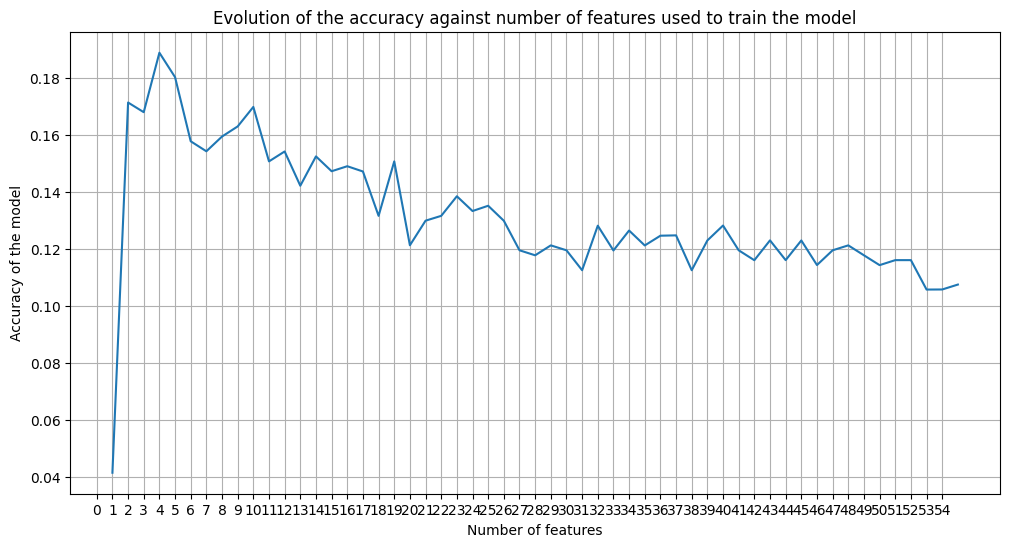

In [51]:
import numpy as np
from sklearn.metrics import make_scorer, precision_score, recall_score

original = np.zeros(55)


recall = make_scorer(recall_score, pos_label="failed")

X_bank_df = pd.DataFrame(X_bank, columns=df.columns[2:])

print(len(X_bank_df.columns))

for i in range(55):
    selector = SelectKBest(mutual_info_classif, k=i+1)
    X_reduced = selector.fit_transform(X2, y_bank)
    cols_idxs = selector.get_support(indices=True)
    nombres = [X_bank_df.columns[j] for j in cols_idxs]
    print(nombres)
    cv = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_scores = cross_val_score(nb.KNeighborsClassifier(), X=X_reduced,y=y_bank, cv=cv, scoring=recall)
    original[i]=np.mean(cv_scores)

fig = plt.figure(figsize = (12, 6))  # Just declare the figure object and give dimensions
plt.grid(True)
plt.title("Evolution of the accuracy against number of features used to train the model")
plt.ylabel("Accuracy of the model")
plt.xlabel("Number of features")
plt.xticks(np.arange(0, 55, step=1))
plt.plot(range(1,56), original)
plt.show()

['Year_1', 'Cost goods sold_1', 'Inventory_1', 'Net income_1', 'Market value_1', 'EBIT_1', 'Gross Profit_1', 'Net income_2', 'Market value_2', 'Net sales_2', 'Long-term debt_2', 'Retained Earnings_2', 'Total Revenue_2', 'EBITDA_3', 'Net income_3', 'Market value_3', 'EBIT_3', 'Gross Profit_3', 'Retained Earnings_3']